## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1> 

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных</h1> 

In [44]:
df = pd.read_csv('sales.csv',  sep=',')
df

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
0,208500,1710,548,7,Pave,Normal
1,181500,1262,460,6,Pave,Normal
2,223500,1786,608,7,Pave,Normal
3,140000,1717,642,7,Pave,Abnorml
4,250000,2198,836,8,Pave,Normal
...,...,...,...,...,...,...
1455,175000,1647,460,6,Pave,Normal
1456,210000,2073,500,6,Pave,Normal
1457,266500,2340,252,7,Pave,Normal
1458,142125,1078,240,5,Pave,Normal


In [45]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (1460, 6)
Пропущенные значения:
SalePrice        0
GrLivArea        0
GarageArea       0
OverallQual      0
Street           0
SaleCondition    0
dtype: int64


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> EDA</h1> 

In [46]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.000000,180921.195890,79442.502883,34900.000000,129975.000000,163000.000000,214000.000000,755000.000000
GrLivArea,1460.000000,1515.463699,525.480383,334.000000,1129.500000,1464.000000,1776.750000,5642.000000
GarageArea,1460.000000,472.980137,213.804841,0.000000,334.500000,480.000000,576.000000,1418.000000
OverallQual,1460.000000,6.099315,1.382997,1.000000,5.000000,6.000000,7.000000,10.000000


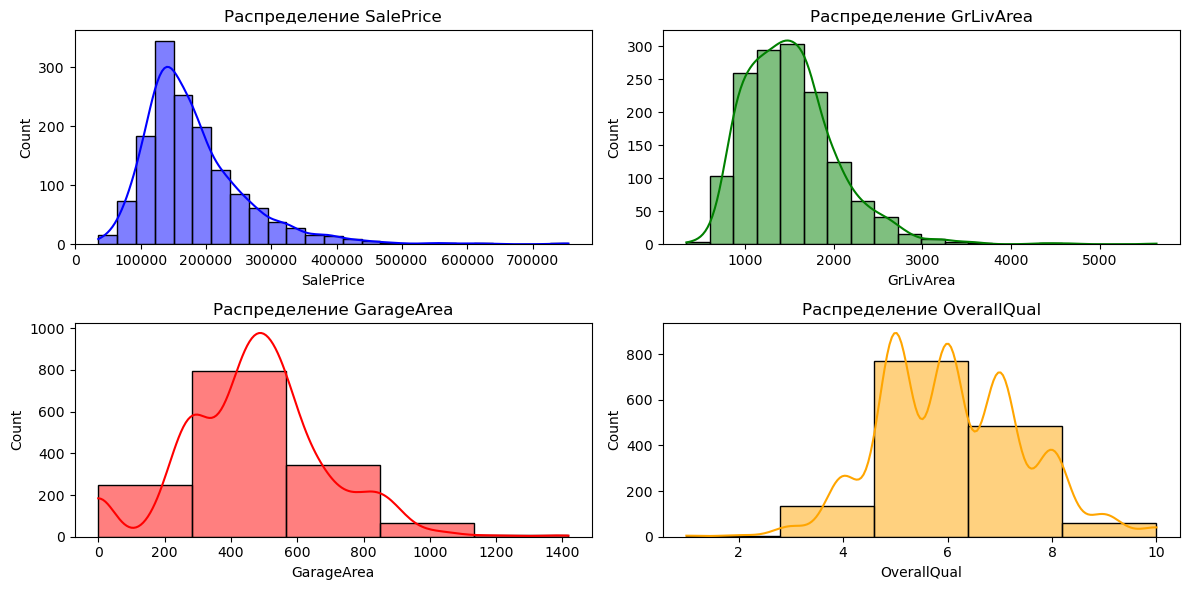

In [47]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['SalePrice'], bins=25, kde=True, color='blue')
plt.title('Распределение SalePrice')

plt.subplot(2, 2, 2)
sns.histplot(df['GrLivArea'], bins=20, kde=True, color='green')
plt.title('Распределение GrLivArea')

plt.subplot(2, 2, 3)
sns.histplot(df['GarageArea'], bins=5, kde=True, color='red')
plt.title('Распределение GarageArea')

plt.subplot(2, 2, 4)
sns.histplot(df['OverallQual'], bins=5, kde=True, color='orange')
plt.title('Распределение OverallQual')

plt.tight_layout()
plt.show()


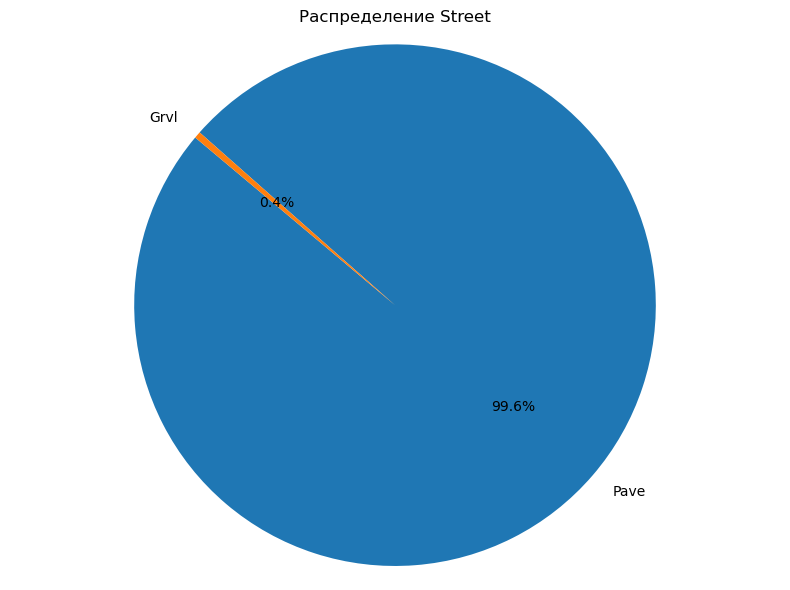

In [48]:
plt.figure(figsize=(8, 6))

plt.pie(df['Street'].value_counts(), labels=df['Street'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение Street')

plt.tight_layout()
plt.show()


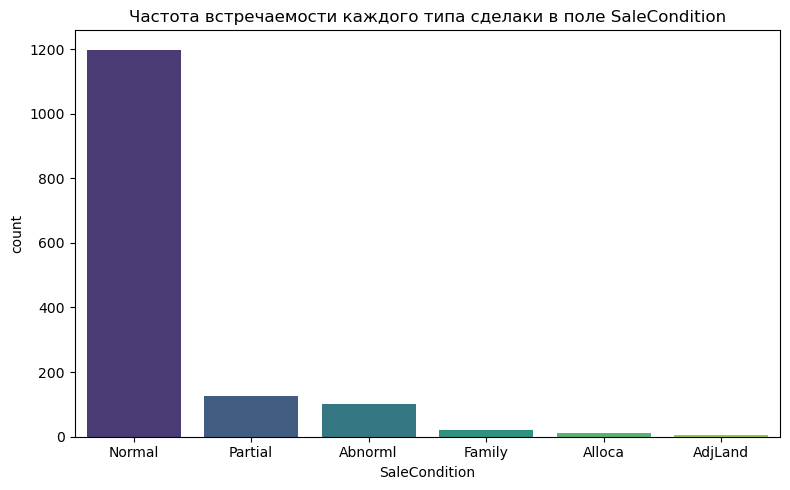

In [49]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(8, 5))

sns.countplot(data=df, x='SaleCondition', palette='viridis', order=df['SaleCondition'].value_counts().index)
plt.title('Частота встречаемости каждого типа сделаки в поле SaleCondition')

plt.tight_layout()
plt.show()


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Подготовка данных</h1> 

In [50]:
# Избавимся от выбросов в числовых полях
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'SalePrice')
df = remove_outliers(df, 'GrLivArea')
df = remove_outliers(df, 'GarageArea')
df = remove_outliers(df, 'OverallQual')

In [51]:
# Удалим строки с Grvl в поле Street в виду их малого количества
# А затем удалим само поле Street, тк в нём останется лишь одно уникальное значение
df = df[df['Street'] != 'Grvl']
unique_values = df['Street'].nunique()
if unique_values == 1:
    df.drop(columns=['Street'], inplace=True)
    

In [52]:
# Из поля SaleCondition удалим строки содержащие значения
# Family, Alloca, AdjLand так как их очень мало в дата-фрейме
df = df[~df['SaleCondition'].isin(['Family', 'Alloca', 'AdjLand'])]


In [53]:
# Преобразуем оставшееся категориальное поле с помощью one-hot encoding
df_conditions = pd.get_dummies(df['SaleCondition'], prefix='SaleCondition')
df = pd.concat([df, df_conditions], axis=1)
df = df.drop(columns=['SaleCondition'])
df

,SalePrice,GrLivArea,GarageArea,OverallQual,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,208500,1710,548,7,False,True,False
1,181500,1262,460,6,False,True,False
2,223500,1786,608,7,False,True,False
3,140000,1717,642,7,True,False,False
4,250000,2198,836,8,False,True,False
...,...,...,...,...,...,...,...
1455,175000,1647,460,6,False,True,False
1456,210000,2073,500,6,False,True,False
1457,266500,2340,252,7,False,True,False
1458,142125,1078,240,5,False,True,False


In [54]:
# Нормализуем признаки
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [55]:
# Разделяем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")

Размер X_train: (1063, 6)
Размер X_test: (266, 6)
Размер y_train: (1063,)
Размер y_test: (266,)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение моделей</h1> 

### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Линейная регрессия</h1> 

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R²: {r2:.2f}')
print(f'rMSE: {rmse:_.2f}')
print(f'MAE: {mae:_.2f}')


R²: 0.80
rMSE: 26_721.57
MAE: 20_244.16


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> MLP </h1> 

In [65]:
mlp = MLPRegressor(hidden_layer_sizes=(50, 10), 
max_iter=1000, 
alpha = 0.01,
solver = 'adam',
random_state=42)
mlp.fit(X_train, y_train)


MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 10), max_iter=1000,
             random_state=42)

In [66]:
y_pred = mlp.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R²: {r2:.2f}')
print(f'rMSE: {rmse:_.2f}')
print(f'MAE: {mae:_.2f}')

R²: 0.64
rMSE: 35_394.10
MAE: 26_861.81
